# Existential Risk Model Solution with Value Function Iteration

This notebook is part of a computational appendix that accompanies the paper

> Existential Risk and The Fermi Paradox
> > Mahon (2021)

Code is adapted from [7 Solution Methods to Solve the Neoclassical Growth Model with Python](https://notes.quantecon.org/submission/5b5f70db9cd7f00015be634e) from the computational appendix of *MATLAB, Python, Julia: What to Choose in Economics?* by Coleman, Lyon, Maliar, and Maliar (2017). 


In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
from scipy.interpolate import interp1d
import time
import matplotlib.pyplot as plt
from collections import namedtuple
from numba import jit, vectorize

## Model Description

There is a fixed population of N homogeneous agents who live up to an infinite number of periods.

There are two control variables: consumption ($ c $), and existential risk mitigation $( w )$. Agents maximize their expected lifetime utility with respect to these two variables. 

The are two state variables: a general [common-pool resource](https://en.wikipedia.org/wiki/Common-pool_resource) (CPR), $ X $, and [total-factor productivity](https://en.wikipedia.org/wiki/Total_factor_productivity) (TFP), $ A $. Each agent's production function relies on how much of the CPR they extract $ x_i $, multiplied by $ A $.   
$$
\begin{equation}
    f(x_i, A) = Ax_i \tag{production function}
\end{equation}
$$    
    
Thus, we have the following for the budget constraint: 
$$ 
\begin{align}
    c_i + w_i &\leq Ax_i \tag{B.C.} \\
    \sum_{i=1}^N x_i &\leq X \\
    \implies C + W &\leq AX; \;\; \text{ where } C \equiv \sum_{i=1}^N c_i, \text{ and } W \equiv \sum_{i=1}^N w_i
\end{align}
$$
Whatever CPR remains at the end of a period goes to the next period multiplied by an exogenous rate of replenishment $ g_x $. Using the notation that primes mean a variables value in the next period, we get the following for the law of motion for the CPR. 
$$
\begin{align}
    X' &= ( X - \sum_{i=1}^N x_i )(1 + g_x) \tag{CPR LLM }\\
    &= (X - \frac{C + W}{A})( 1 + g_x )
\end{align}
$$
     
The TFP grows at a constant exponential rate, $ g_a $:
$$
\begin{equation}
    A' = A(1 + g_a)
\end{equation}
$$  

We can combine these last two equations by multiplying the CPR LLM by $  A(1 + g_a) $:
$$
\begin{equation}
    A'X' = (AX - C - W)( 1 + g_x )(1 + g_a) 
\end{equation}
$$ 
    
To simply, denote $ \tilde{X} := A'X' $ and $ g := g_x + g_a + g_x g_a $, such that $ ( 1 + g) = ( 1 + g_x)(1 + g_a) $. Now the problem can be expressed in terms of a single state variable, $ \tilde{X} $. 
$$
\begin{align}
    \tilde{X}' &= (\tilde{X} - C - W)( 1 + g) \\
    C + W &\leq \tilde{X} 
\end{align}
$$ 


The instantaneous utility is a log-utility functon, and we assume the utility of death is zero, i.e. agents are indifferent to being dead and consuming just 1 unit of consumption because $\ln(1) = 0 $, and they prefer death over $ c < 1 $, and prefer life over $ c > 1 $. Future utility is discounted by the subjective discount factor, $ \beta \in [0,1) $. 

There is an endogenous probability of a doomsday event at the end of each period based on the ratio of the current period's total consumption, $ C $, and total existential risk mitigation, $ W $. The scalar constant, $ \bar{a} $, scales the relative effect of $ W $ versus $ C $ on this probability. 
$$
\Pr(\text{ Existiential Disaster } | C, W ) = \frac{C}{C + \bar{a} W}
$$

The agent's problem can be written recursively using the following Bellman equation:

$$
\begin{align*}
    V(\tilde{X}) &= \max_{c_i,w_i} \biggl\{\ln(c_i) + \beta E \bigl[V(\tilde{X}') | C, W\bigr] \biggr\}\\
    & \text{ s.t. } c_i \geq 0; \qquad s_i \geq 0 \\
    & \phantom{\text{ s.t. } } C + W \leq \tilde{X}\\
    & \phantom{\text{ s.t. } } \tilde{X}' = (\tilde{X} - C - W)(1 + g) 
\end{align*} 
$$

Note:
$$
\begin{align}
    E \bigl[V(\tilde{X}') | C, W\bigr] &= \bigg( 1 - \Pr(\text{ Existiential Disaster } | C, W )\bigg)V(\tilde{X}') \\
    &= \frac{\bar{a}W}{C + \bar{a} W}V(\tilde{X}') 
\end{align} 
$$
    
Thus, the problem can be expressed deterministically:
$$
\begin{align*}
    V(\tilde{X}) &= \max_{c_i,w_i} \biggl\{\ln(c_i) + \beta \frac{\bar{a}W}{C + \bar{a} W} V(\tilde{X}')\biggr\}\\
    & \text{ s.t. } c_i \geq 0; \qquad s_i \geq 0 \\
    & \phantom{\text{ s.t. } } C + W \leq \tilde{X}\\
    & \phantom{\text{ s.t. } } \tilde{X}' = (\tilde{X} - C - W)(1 + g) 
\end{align*} 
$$

## Python Code

We begin by defining a `namedtuple` that contains the parameters of our model. This is useful to pass the parameters around to functions that are just-in-time (JIT) compiled by `numba`.

In [2]:
#
# Create a named tuple type that we can pass into the jitted functions
# so that we don't have to pass parameters one by one
#
Params = namedtuple("Params", ["N", "beta", "g", "a_bar"])

@jit(nopython=True)
def param_unpack(params):
    "Unpack parameters from the Params type"
    out = (params.N, params.beta, params.g,
           params.a_bar)

    return out

We will then define various helper functions to ensure that we [don't repeat ourselves](https://lectures.quantecon.org/py/writing_good_code.html#don-t-repeat-yourself) and that the inner functions can be JIT compiled.

In [3]:
#
# Helper functions to make sure things are jitted
#
@vectorize(nopython=True)
def u(c):
    "log utility function"
    return -1e10 if c < 1e-10 else np.log(c)

@vectorize(nopython=True)
def psurvival(a_bar, c, w):
    return a_bar*w/(c + a_bar*w)


## Envelope Condition 

Denote the optimal $ \tilde{X}' $ as $ \tilde{X}^{\prime \ast} $ and the optimal $ c $ and $ w $ as $ c^\ast $ and $ w^\ast $. 

$ \tilde{X}^{\prime \ast}$ is defined as the following:
$$ \begin{equation}
\tilde{X}^{\prime \ast} \equiv (\tilde{X} - C(c^\ast) - W(w^\ast))(1 + g)
\end{equation}
$$
With total consumption $ C $ and total risk reduction investment $ W $ expressed as functions of the representative agents choices. 

$ W(w^\ast) $ can now be expressed as:
$$ \begin{equation}
W(w^\ast) = \tilde{X}  - \frac{\tilde{X}^{\prime \ast}}{1 + g} - C(c^\ast)
\end{equation}
$$
Thus, fixing $ w $ and $ \tilde{X}' $ at the optimum, the problem can be described with consumption as the only control variable:
$$
\begin{align*}
    V(\tilde{X}) &= \max_{c} \biggl\{\ln(c) + \beta \frac{\bar{a}\bigg( \tilde{X} - \frac{\tilde{X}^{\prime \ast} }{1 + g} - C(c)\bigg)}{C(c) + \bar{a} \bigg( \tilde{X} - \frac{\tilde{X}^{\prime \ast} }{1 + g} - C(c) \bigg)} V(\tilde{X}^{\prime\ast} )\biggr\}
\end{align*} 
$$
We can now solve for $ c^\ast $ using the FOC:
$$
\begin{align}
c^\ast &= - \Bigg\{ \beta V(\tilde{X}^{\prime \ast}) \frac{d}{dc}\Bigg(\frac{\bar{a}\bigg( \tilde{X} - \frac{\tilde{X}^{\prime \ast} }{1 + g} - C(c)\bigg)}{C(c) + \bar{a} \bigg( \tilde{X} - \frac{\tilde{X}^{\prime \ast} }{1 + g} - C(c) \bigg)} \Bigg) \Bigg\}^{-1}
\end{align}
$$


#### Social Optimum
At the social optimum, we maximize w.r.t. to the same $ c $ for everyone so, $ C(c) = Nc $. Thus, at the social optimum we get the following for $ c^\ast $ from the first order condition.
$$ 
\begin{align*}
    c^\ast &=  \frac{\bar{a} (X(1 + g) - \tilde{X}^{\prime \ast} ) \bigg(2 (\bar{a} - 1) + \beta V(\tilde{X}^{\prime \ast})  - \sqrt{\beta V(\tilde{X}^{\prime \ast})  \bigg(\beta V(\tilde{X}^{\prime \ast}) + 4 (\bar{a} - 1 )\bigg)}\bigg)}{2 N (\bar{a} - 1)^2 (1 + g)}
\end{align*}
$$

In [4]:
@vectorize(nopython=True)
def so_foc_c(X, Xp, Vp, a_bar, beta, N, g):
    """
    Social optimum c expressed in terms of optimal X' from first order condition.
    Ensure values can not be negative nor exceed X/N
    """
    return (
            a_bar*(X*(1 + g) - Xp)*(
                2*(a_bar - 1) + beta*Vp - (
                    beta*Vp*(
                        beta*Vp + 4*(a_bar - 1)
                    )
                )**0.5
            )
        )/(
            2*N*((a_bar - 1)**2)*(1 + g)
        )

@vectorize(nopython=True)
def so_foc_w(X, Xp, N, g, c):
    "Social optimum w expressed in terms of optimal X' and c from first order condition"
    return (X - Xp/(1 + g) - N*c)/N



#### Market Equilibrium
At the market equilibrium, agent's maximize their own individual utility with respect to their own choices for $ c $ and $ w $. They optimize against the other agents' choices, which we donote as $ \bar{c} $ and $ \bar{w} $. All other agents must make the same choice since this is a homogeneous agent model. Thus we can treat $ \bar{c} $ as fixed and $ C(c) $ becomes $ c + (N-1)\bar{c} $, and now we can use the same process to find $ c^\ast $ in terms of the optimal $ \tilde{X}^{\prime \ast } $ and the model conditions, which include the strategies of the other agents. The result to this FOC is much longer than the one for the social optimum, so rather than showing it here, the equation was just computed in MATLAB, and has been adapted to the Python function below:

In [5]:
@vectorize(nopython=True)
def me_foc_c(X, Xp, Vp, a_bar, beta, N, g, c_bar):
    "Market Equilibrium c expressed in terms of optimal X' from first order condition"
    return (
        2*c_bar - (
          Vp*a_bar*beta*(X - Xp + X*g)*(
            4*c_bar 
            - 4*N*c_bar 
            - 4*X*a_bar 
            + 4*Xp*a_bar 
            - 8*a_bar*c_bar 
            + 4*c_bar*g 
            + 4*X*a_bar**2 
            - 4*Xp*a_bar**2 
            + 4*a_bar**2*c_bar 
            + 8*N*a_bar*c_bar 
            - 4*N*c_bar*g 
            - 4*X*a_bar*g 
            - 8*a_bar*c_bar*g 
            - 4*N*a_bar**2*c_bar 
            + 4*X*a_bar**2*g 
            + 4*a_bar**2*c_bar*g 
            - 4*N*a_bar**2*c_bar*g 
            + Vp*X*a_bar*beta 
            - Vp*Xp*a_bar*beta 
            + 8*N*a_bar*c_bar*g 
            + Vp*X*a_bar*beta*g
            )
        )**(1/2) 
        - 2*N*c_bar 
        - 2*X*a_bar 
        + 2*Xp*a_bar 
        - 4*a_bar*c_bar 
        + 2*c_bar*g 
        + 2*X*a_bar**2 
        - 2*Xp*a_bar**2 
        + 2*a_bar**2*c_bar 
        + 4*N*a_bar*c_bar 
        - 2*N*c_bar*g 
        - 2*X*a_bar*g 
        - 4*a_bar*c_bar*g 
        - 2*N*a_bar**2*c_bar 
        + 2*X*a_bar**2*g 
        + 2*a_bar**2*c_bar*g 
        - 2*N*a_bar**2*c_bar*g 
        + Vp*X*a_bar*beta 
        - Vp*Xp*a_bar*beta 
        + 4*N*a_bar*c_bar*g 
        + Vp*X*a_bar*beta*g
      )/(
        2*(
          g - 2*a_bar - 2*a_bar*g + a_bar**2*g + a_bar**2 + 1
        )
      )

@vectorize(nopython=True)
def me_foc_w(X, Xp, N, c_bar, w_bar, c):
    "Market Eq'm w expressed in terms of optimal X' and c from first order condition"
    return X - Xp/(1 + g) - (N-1)*(c_bar + w_bar) - c


### The Policy and Value Function 

Now that we can derive $ c^\ast $ and $ w^\ast $ from $ \tilde{X}^{\prime \ast } $ and $ V(\tilde{X}^{\prime \ast }) $, we just need to find functions for these two values in terms of the current state $ \tilde{X} $. A policy function: $ \widehat{\tilde{X}^{\prime \ast } }(\tilde{X})$, and a value function: $ \widehat{V}(\tilde{X}) $. 

However, traditional approaches to this particular model will not work because until the model is solved, we can not know how many periods this economy will survive until. Given some initial conditions the equilibrium may be for the CPR to potentially stay positive forever. Other conditions could lead to the CPR being entirely depleted in one period, or depleted in $ n $ periods from the present. Thus, this model has an endogenous time horizon, $ \in [0, \infty) $. This means that no analytical function could fully express these solutions on their, and because the state could also grow infinitely, traditional non-analytic approaches, such as spline functions will do a poor job of extrapolating values outside of the fitted range. 

This leads us to the following two-part approach. We will use a linear spline for low state values, $ \tilde{X} $, where there is a lot of discontinuity, and an analytic function for high $ \tilde{X} $, which could competently extrapolate estimates for $ \tilde{X} $ higher than what it was fitted on.

Through trial and error, we find that on the analytic portion of the domain for these functions, $ \widehat{\tilde{X}^{\prime \ast } }(\tilde{X}; b) $ follows a simple linear equation:
$$
\begin{align}
 \widehat{\tilde{X}^{\prime \ast } }(\tilde{X}; b) = b_0 + b_1\tilde{X}
\end{align}
$$

And $ \widehat{V}(\tilde{X}; b) $ can be estimated with the following nonlinear functional form:
$$
\widehat{V}(\tilde{X}; b) = b_0 + b_1 \frac{\ln(\tilde{X})}{b_2 - \tilde{X}^{b_3}}
$$

Their Python functions are shown below. 

In [6]:
def x_curve(x, b0, b1):
    "X' policy function curve"
    return b0 + b1*x


def v_curve(x,  b0, b1, b2, b3):
    "Value function curve"
    return b0 + b1*np.log(x)/(b2 - (x**b3))

We also now define a class that contains

1. Parameters of the model
2. A grid used for approximating the solution

This again helps us maintain all of the relevant information in one place and simplifies passing it to other functions.

In [7]:
class ExistentialRiskModel(object):
    """
    * N: Population Size
    * beta: subjective discount factor
    * g_x: CPR regrowth rate
    * g_a: TFP growth rate
    * a_bar: Exisitentail risk reduction scaling parameter
    """
    def __init__(self, N=1, beta=0.95, g_x=0.05, g_a=0.015, a_bar=1e5, 
                 xmin_l=2, xmax_l=200, nx_l=25, linspace_l=True,
                 xmin_h=250, xmax_h=2500, nx_h=100, linspace_h=False):
        # calculate g from g_a and g_x 
        g = g_a + g_x + g_a*g_x

        # Household parameters
        self.beta = beta

        # Economy parameters
        self.N, self.g, self.a_bar = N, g, a_bar

        # Create x grid for spline interpolation domain
        # xmin and xmax refer to the X minimum and maximum per agent, so they must be scaled up by N.
        if linspace_l:
            self.xgrid_l = N*np.linspace(xmin_l, xmax_l, nx_l)
        else:
            self.xgrid_l = N*np.geomspace(xmin_l, xmax_l, nx_l)
        
        # Create x grid for analytic function domain
        if linspace_h:
            self.xgrid_h = N*np.linspace(xmin_h, xmax_h, nx_h)
        else:
            self.xgrid_h = N*np.geomspace(xmin_h, xmax_h, nx_h)
            
        # concatenate into a single grid
        self.xgrid = np.concatenate([self.xgrid_l, self.xgrid_h])
        # store the state value that splits the two parts of the solution and its index in the xgrid
        self.xsplit = self.xgrid_l[-1]
        self.xsplit_idx = nx_l
        
        self.ns = nx_l + nx_h
        
    def _unpack_params(self):
        out = (self.N, self.beta, self.g, self.a_bar)
        return out

    def _unpack_grids(self):
        out = (self.xgrid)
        return out


In [8]:
class GeneralSolution:
    """
    This is a general solution method. We define this, so that we can
    sub-class it and define specific update methods for each particular
    solution method
    """
    def __init__(self, erm, prev_sol=None, maxfev=10000, interpolator='linear'):
        # Save model and approximation degree
        self.erm,  self.maxfev, self.interpolator = erm, maxfev, interpolator

        # Unpack some info from erm
        N, beta, g, a_bar = self._unpack_params()
        X = self.erm.xgrid
        self.xsplit = self.erm.xsplit
        self.xsplit_idx = self.erm.xsplit_idx
        

        # Use parameter values from model to create a namedtuple with
        # parameters saved inside
        self.params = Params(N, beta, g, a_bar)

        # Update to fill initial value and policy matrices
        # If we give it another solution type then use it to
        # generate values and policies
        if issubclass(type(prev_sol), GeneralSolution):
            self.XP = prev_sol.XP
            self.VF = prev_sol.VF
        # If we give it a tuple then assume it is (policy, value) pair
        elif type(prev_sol) is tuple:
            self.XP = prev_sol[0]
            self.VF = prev_sol[1]
        # Otherwise guess a value and policy function
        else:
            # guess VF and XP
            self.VF = np.log(X/N) 
            self.XP = X

            
        # Fit spline based on guesses
        self.x_spline = interp1d(X[:self.xsplit_idx]
                                 , self.XP[:self.xsplit_idx]
                                 , kind=self.interpolator
                                 , fill_value='extrapolate')
        self.v_spline = interp1d(X[:self.xsplit_idx]
                                 , self.VF[:self.xsplit_idx]
                                 , kind=self.interpolator
                                 , fill_value='extrapolate')
        
        # Fit coefficients of analytics functions based on guesses
        self.x_coeffs, _ = opt.curve_fit(x_curve
                                         , X[self.xsplit_idx:]
                                         , self.XP[self.xsplit_idx:]
                                         , maxfev=self.maxfev)
        self.v_coeffs, _ = opt.curve_fit(v_curve
                                         , X[self.xsplit_idx:]
                                         , self.VF[self.xsplit_idx:]
                                         , maxfev=self.maxfev)
    
    def build_VF(self, X=None):
        """
        Using the current coefficients, this builds the value function
        for all states
        """
        if X is None:
            X = self.erm.xgrid
        
        VF = np.maximum(0, np.where(X > self.xsplit
                        , v_curve(X, *self.v_coeffs)
                        , self.v_spline(X)
                    ))
                

        return VF
    
    def build_XP(self, X=None):
        if X is None:
            X = self.erm.xgrid
        
        XP = np.where(X > self.xsplit
                        , np.clip(x_curve(X, *self.x_coeffs)
                                  , 0, X*(1 + self.erm.g))
                        , self.x_spline(X))
        
        return XP
    
    
    def compute_coeffs(self, XP, VF):
        if isinstance(self, IterateOnPolicy):
            new_x_coeffs = self.x_coeffs
        else:
            new_x_coeffs, _ = opt.curve_fit(x_curve
                                            , self.erm.xgrid[self.xsplit_idx:]
                                            , XP[self.xsplit_idx:]
                                            , maxfev=self.maxfev)
        
        new_v_coeffs, _ = opt.curve_fit(v_curve
                                        , self.erm.xgrid[self.xsplit_idx:]
                                        , VF[self.xsplit_idx:]
                                        , maxfev=self.maxfev) 
        
        return new_x_coeffs, new_v_coeffs
    
    def compute_splines(self, XP, VF):
        if isinstance(self, IterateOnPolicy):
            new_x_spline = self.x_spline
        else:
            new_x_spline = interp1d(self.erm.xgrid[:self.xsplit_idx]
                                    , XP[:self.xsplit_idx]
                                    , kind=self.interpolator
                                    , fill_value='extrapolate')
        
        new_v_spline = interp1d(self.erm.xgrid[:self.xsplit_idx]
                                , VF[:self.xsplit_idx]
                                , kind=self.interpolator
                                , fill_value='extrapolate')
        
        return new_x_spline, new_v_spline

    def _unpack_params(self):
        return self.erm._unpack_params()

    def update_v(self, new_v_coeffs, new_v_spline):
        """
        Updates the coefficients for the value function
        """
        self.v_coeffs = new_v_coeffs
        self.v_spline = new_v_spline

        return None

    def update_x(self, new_x_coeffs, new_x_spline):
        """
        Updates the coefficients for the policy function
        """
        self.x_coeffs = new_x_coeffs
        self.x_spline = new_x_spline
        
        return None
    

    def compute_distance(self, XP, VF):
        """
        Computes average distance between policy functions
        """
        return np.max(np.abs(1.0 - (XP+1e-12)/(self.XP+1e-12)))
    

    def solve(self, tol=1e-6, maxiter=2500, verbose=False, nskipprint=25):
        # Iterate until convergence
        dist, it = 10.0, 0
        while (dist>tol) and (it<maxiter):
            # Run solution specific update code
            XP, VF = self.update()
            

            # Compute new policy and value coeffs
            new_x_coeffs,  new_v_coeffs = self.compute_coeffs(XP, VF)
            new_x_spline, new_v_spline = self.compute_splines(XP, VF)

            # Update distance and iterations
            dist = self.compute_distance(XP, VF)
            self.XP, self.VF = XP, VF
            it += 1
            if verbose and it%nskipprint == 0:
                print(it, dist)

            # Update all coefficients
            self.update_x(new_x_coeffs, new_x_spline)
            self.update_v(new_v_coeffs, new_v_spline)

        # After finishing iteration, iterate to convergence using policy
        if not isinstance(self, IterateOnPolicy):
            if isinstance(self, SocialOptimum):
                sol_iop = IterateOnPolicySO(self.erm, prev_sol=self, maxfev=self.maxfev)
            elif isinstance(self, MarketEquilibrium):
                sol_iop = IterateOnPolicyME(self.erm, prev_sol=self, maxfev=self.maxfev)
                
            # error if sol_iop undefined
            XP, VF = sol_iop.solve(tol=1e-6)

            # Save final versions of everything
            self.XP, self.VF = XP, VF
            
            new_x_coeffs, new_v_coeffs = sol_iop.compute_coeffs(XP, VF)
            new_x_spline, new_v_spline = sol_iop.compute_splines(XP, VF)
            self.update_x(new_x_coeffs, new_x_spline)
            self.update_v(new_v_coeffs, new_v_spline)

        return self.XP, self.VF
    
    """
    This is where we run the Bellman operator on the policy and value functions.
    Updating their new values on each iteration until convergence
    """
    def update(self):
        # Unpack parameters
        N, beta, g, a_bar = self._unpack_params()
        xgrid = self.erm.xgrid
        n_state = xgrid.shape[0]

        # Get the policy and update it
        XP = np.empty(n_state)
        VF = np.empty(n_state)
        for i_s in range(n_state):
            # Pull out current state
            X = xgrid[i_s]        
            
            _xp = opt.fminbound(lambda _xp: -self.compute_V(X=X, XP=_xp)**2
                                , 0, X*(1+g), xtol=1e-12)
                         
            XP[i_s] = _xp
            VF[i_s] = self.compute_V(X=X, XP=_xp)

        return XP, VF
        


In [9]:
class SocialOptimum(GeneralSolution):
    """
    Updates the coefficients and value functions using the VFI
    method
    """
    def build_CP(self, X=None, XP=None, Vp=None):
        N, beta, g, a_bar = self._unpack_params()
        
        if X is None:
            X = self.erm.xgrid
        
        if XP is None:
            XP = self.build_XP(X)
            
        if Vp is None:
            Vp = self.build_VF(XP)
            
        return so_foc_c(X, XP, Vp, a_bar, beta, N, g)
    
    def build_WP(self, X=None, XP=None, CP=None):
        N, beta, g, a_bar = self._unpack_params()
        
        if X is None:
            X = self.erm.xgrid
        
        if XP is None:
            XP = self.build_XP(X)
            
        if CP is None:
            CP = self.build_CP(X=X, XP=XP)
        
        return so_foc_w(X, XP, N, g, CP)
    
    def compute_V(self, X=None, XP=None, Vp=None, CP=None, WP=None):
        # Unpack parameters
        N, beta, g, a_bar = self._unpack_params()
        
        if Vp is not None and CP is not None and WP is not None:
            VF = u(CP) + beta*psurvival(a_bar, CP, WP)*Vp
            
        else:
            if X is None:
                X = self.erm.xgrid
                
            if XP is None:
                XP = self.build_XP(X)
                
            if Vp is None:
                Vp = self.build_VF(XP)
                
            if CP is None:
                CP = self.build_CP(X=X, XP=XP, Vp=Vp) 
                
            if WP is None:
                WP = self.build_WP(X=X,XP=XP,CP=CP) 
                
            VF = u(CP) + beta*psurvival(a_bar, CP, WP)*Vp
            
        return np.maximum(0, VF)

    
    def simulate(self, X=None, T=1000, s=1):
        """
        Simulates the existential risk model with policy function
        given by self.XP. Run Simulation for T periods, and use s 
        to scale policy function estimates to check how well model 
        performs compared to slight modifications. The simulation results
        should ideally be highest when s=1. 
        """
        N, beta, g, a_bar = self._unpack_params()
        # X is starting point, if None, set to N*274
        if X is None:
            X = N*274
            
        def recurse_bellman(x, t):
            if x <= 0:
                return 0, 0, x, t
            if t >= min(T, 2000):
                return u(x/N), 1, x, t
            c_corner = x/N 
            u_corner = u(c_corner)
            if u_corner <= 0:
                return 0, 0, x, t
            
            xp = self.build_XP(x)
            if xp <= 0:
                return u_corner, 0, 0, t+1
            if s != 1:
                xp = s*xp
            xp = min(xp, x*(1+g)-1e-10) # xp = x*(1+g), would result in c = 0, log(0)= -infinity in current period
            
            vp_hat = self.build_VF(xp)
            c = np.clip(self.build_CP(X=x,XP=xp,Vp=vp_hat)
                        ,1e-10,c_corner)
            w = self.build_WP(X=x, XP=xp, CP=c)
            
            p_t = psurvival(a_bar, c, w)
            u_t = u(c)
            
            vp, pp, final_state, nperiods = recurse_bellman(xp, t+1)            
            
            if u_t + beta*p_t*vp <= u_corner:
                return u_corner, 0, 0, t+1
            
            return u_t + beta*p_t*vp, p_t*pp, final_state, nperiods
        
        T_counter = 0 
        psurvived = 1
        total_VP = 0
        while T > 0:
            vp, pp, X, nperiods = recurse_bellman(X, 0)
            total_VP += beta**(T_counter)*psurvived*vp
            psurvived *= pp
            T_counter += nperiods
            T -= 2000
            
        return total_VP, psurvived, X, T_counter

In [10]:
class MarketEquilibrium(GeneralSolution):
    """
    Updates the coefficients and value functions using the VFI
    method
    """
    def __init__(self, *args, **kwargs):
        # prev_sol must be passed
        super().__init__(*args, **kwargs)
        self.prev_sol = kwargs['prev_sol']
        self.CP_bar = self.prev_sol.build_CP(X=self.erm.xgrid)
        self.WP_bar = self.prev_sol.build_WP(X=self.erm.xgrid)
        
    def build_CP(self, X=None, XP=None, Vp=None, CP_bar=None):
        N, beta, g, a_bar = self._unpack_params()
        
        if X is None:
            X = self.erm.xgrid
        
        if XP is None:
            XP = self.build_XP(X)
            
        if Vp is None:
            Vp = self.build_VF(XP)
            
        if CP_bar is None:
            CP_bar = self.prev_sol.build_CP(X=X, XP=XP, Vp=Vp)
            
        return me_foc_c(X, XP, Vp, a_bar, beta, N, g, CP_bar)
    
    def build_WP(self, X=None, XP=None, CP=None, CP_bar=None, WP_bar=None):
        N, beta, g, a_bar = self._unpack_params()
        
        if X is None:
            X = self.erm.xgrid
        
        if XP is None:
            XP = self.build_XP(X)
            
        if CP_bar is None:
            CP_bar = self.prev_sol.build_CP(X=X)
            
        if WP_bar is None:
            WP_bar = self.prev_sol.build_WP(X=X, CP=CP_bar)
            
        if CP is None:
            CP = self.build_CP(X=X, XP=XP, CP_bar=CP_bar)
        
        return me_foc_w(X, XP, N, CP_bar, WP_bar, CP)
    
    def compute_V(self, X=None, XP=None, Vp=None, CP=None, WP=None, CP_bar=None, WP_bar=None):
        # Unpack parameters
        N, beta, g, a_bar = self._unpack_params()
        
        if Vp is not None and CP is not None and WP is not None and CP_bar is not None and WP_bar is not None:
            VF = u(CP) + beta*psurvival(a_bar, CP + (N-1)*CP_bar, WP + (N-1)*WP_bar)*Vp
            
        else:
            if X is None:
                X = self.erm.xgrid
                
            if XP is None:
                XP = self.build_XP(X)
                
            if Vp is None:
                Vp = self.build_VF(XP)
            
            if CP_bar is None:
                CP_bar = self.prev_sol.build_CP(X=X)
                
            if WP_bar is None:
                WP_bar = self.prev_sol.build_WP(X=X, CP=CP_bar)
                
            if CP is None:
                CP = self.build_CP(X=X, XP=XP, Vp=Vp, CP_bar=CP_bar) 
                
            if WP is None:
                WP = self.build_WP(X=X,XP=XP,CP=CP, CP_bar=CP_bar, WP_bar=WP_bar) 
                
            VF = u(CP) + beta*psurvival(a_bar, CP + (N-1)*CP_bar, WP + (N-1)*WP_bar)*Vp
            
        return np.maximum(0, VF)

    
    def simulate(self, X=None, T=1000, s=1):
        """
        Simulates the existential risk model with policy function
        given by self.XP. Run Simulation for T periods, and use s 
        to scale policy function estimates to check how well model 
        performs compared to slight modifications. The simulation results
        should ideally be highest when s=1. 
        """
        N, beta, g, a_bar = self._unpack_params()
        # X is starting point, if None, set to N*274
        if X is None:
            X = N*274
            
        def recurse_bellman(x, t):
            if x <= 0:
                return 0, 0, x, t
            if t >= min(T, 2000):
                return u(x/N), 1, x, t
            c_corner = x/N 
            u_corner = u(c_corner)
            if u_corner <= 0:
                return 0, 0, x, t
            
            xp = self.build_XP(x)
            if xp <= 0:
                return u_corner, 0, 0, t+1
            if s != 1:
                xp = s*xp
            xp = min(xp, x*(1+g)-1e-10) # xp = x*(1+g), would result in c = 0, log(0)= -infinity in current period
            
            vp_hat = self.build_VF(xp)
            c = np.clip(self.build_CP(X=x,XP=xp,Vp=vp_hat)
                        ,1e-10,c_corner)
            w = self.build_WP(X=x, XP=xp, CP=c)
            
            p_t = psurvival(a_bar, c, w)
            u_t = u(c)
            
            vp, pp, final_state, nperiods = recurse_bellman(xp, t+1)            
            
            if u_t + beta*p_t*vp <= u_corner:
                return u_corner, 0, 0, t+1
            
            return u_t + beta*p_t*vp, p_t*pp, final_state, nperiods
        
        T_counter = 0 
        psurvived = 1
        total_VP = 0
        while T > 0:
            vp, pp, X, nperiods = recurse_bellman(X, 0)
            total_VP += beta**(T_counter)*psurvived*vp
            psurvived *= pp
            T_counter += nperiods
            T -= 2000
            
        return total_VP, psurvived, X, T_counter

### Iterating to Convergence (given policy)

This isn't one of the methods described above, but it is used as an element of a few of our methods (and also as a way to get a first guess at the value function). This method takes an initial policy function, $\widehat{\tilde{X}^{\prime\ast}}(\tilde{X})$, as given, and then, without changing the policy, iterates until the value function has converged.

Thus the "update section" of the algorithm in this instance would be:

* Leave policy function unchanged
* At each point of grid, $(\tilde{X})$, compute $V(\tilde{X}) = u(c(\widehat{\tilde{X}^{\prime\ast}}(\tilde{X})) + \beta E \left[ \widehat{V}(\widehat{\tilde{X}^{\prime\ast}}(\tilde{X})) \right]$

We override the methods from `GeneralSolution`

* `compute_distance` because when we are iterating to convergence on the value function we want to check distnace using value function rather than policy function


The `update` method just repeatedly applies a particular policy function to update the value function.

In [11]:
class IterateOnPolicy(GeneralSolution):
    def compute_distance(self, XP, VF):
        """
        Computes distance between policy functions. When we are
        iterating on a specific policy, we would like to compute
        distances by the difference between VFs
        """
        return np.max(np.abs(1.0 - (VF )/(self.VF )))

class IterateOnPolicySO(IterateOnPolicy, SocialOptimum):
    def update(self):
        VF = self.compute_V()
        
        return self.XP, VF
    
class IterateOnPolicyME(IterateOnPolicy, MarketEquilibrium):
    def update(self):
        VF = self.compute_V(CP_bar=self.CP_bar, WP_bar=self.WP_bar)
        
        return self.XP, VF

## Run Solution

To start we can initialize the model

In [37]:
erm = ExistentialRiskModel(N=5, a_bar=1e5, beta=0.95, g_x=0.05, 
             xmin_l=2, xmax_l=100, nx_l=25, linspace_l=True,
             xmin_h=105, xmax_h=3000, nx_h=100, linspace_h=False
            )

Now we can iterate over the policy function guess to fit a value function

In [38]:
# First guess
vp = IterateOnPolicySO(erm, maxfev=50000, interpolator='linear')
vp.solve(tol=1e-9)
print('vp done')

vp done


/Users/mikemahon/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-11-416df50f87cb>:8: RuntimeWarning: invalid value encountered in true_divide
  return np.max(np.abs(1.0 - (VF )/(self.VF )))


### Solving for Social Optimum 

Pass the value function result from the initial guess into the SocialOptimum solution class. Then call .solve() to perform value function iteration until we find a fixed point where the value function and policy functions converge

In [39]:
soc_opt_sol = SocialOptimum(erm, maxfev=100000, prev_sol=vp, interpolator='linear')
ts = time.time()
soc_opt_sol.solve(tol=1e-6, verbose=True, nskipprint=25)
time_took = time.time() - ts

<ipython-input-6-f5da8011af91>:8: RuntimeWarning: overflow encountered in double_scalars
  return b0 + b1*np.log(x)/(b2 - (x**b3))


25 0.00165413841265305
50 0.00031287764560183895
75 0.00013261574418632627
100 2.4511373598379294e-05
125 6.132362251554113e-06
150 1.6612648185976298e-06


<ipython-input-6-f5da8011af91>:8: RuntimeWarning: overflow encountered in power
  return b0 + b1*np.log(x)/(b2 - (x**b3))


In [40]:
N, beta, g, a_bar = soc_opt_sol._unpack_params()
X = soc_opt_sol.erm.xgrid
VF = soc_opt_sol.VF
XP = soc_opt_sol.XP
Vp = soc_opt_sol.build_VF(XP)
CP = soc_opt_sol.build_CP(X=X, XP=XP, Vp=Vp)
WP = soc_opt_sol.build_WP(X=X, XP=XP, CP=CP)

<ipython-input-6-f5da8011af91>:8: RuntimeWarning: overflow encountered in power
  return b0 + b1*np.log(x)/(b2 - (x**b3))


# Social Optimum Results

In [41]:
VF2 = me_sol.VF
XP2 = me_sol.XP
Vp2 = me_sol.build_VF(XP2)
CP2 = me_sol.build_CP(X=X, XP=XP2, Vp=Vp2)
WP2 = me_sol.build_WP(X=X, XP=XP2, CP=CP2)

## Results table

* **X** is the model state, which represents the effective CPR ($ \tilde{X} = AX $). It is shown divided by N, the number of agents in the model, because that is a bit easier to interpret.

* **XP**: policy function estimates for $ \tilde{X}^{\prime \ast } $ taken at the grid points  **X**

* **VF**: value function estimates 

* **CP**: consumption policy function estimates which we get from **XP** using the envelope theorem. 

* **WP**: existential risk mitigation policy estimates, which we get from **XP** and **CP** using the envelope theorem. 

* **CP/WP** : the ratio of optimal consumption versus existential risk mitigation

* **X_dot**  : the change in $ X $ in one unit of time, usually denoted as $ \dot{X} $

* **X_dot/X** : the rate of change in X

In [42]:
sol_df = pd.DataFrame({
    'X/N': X/N,
    'XP/N': XP/N,
    'VF': VF,
    'CP': CP,
    'WP': WP,
    'CP/WP': CP/WP,
    'X_dot': XP-X,
    'X_dot/X': (XP-X)/X
})
sol_df.style

,X/N,XP/N,VF,CP,WP,CP/WP,X_dot,X_dot/X
0,2.000000,0.000000,0.693157,2.000020,-0.000020,-100000.000001,-10.000000,-1.000000
1,6.083333,3.646188,2.212464,2.652759,0.009333,284.244929,-12.185724,-0.400627
2,10.166667,8.052261,3.759916,2.597398,0.013781,188.478581,-10.572029,-0.207974
3,14.250000,12.467092,5.342616,2.535165,0.016883,150.158237,-8.914540,-0.125116
4,18.333333,16.893721,6.969723,2.462601,0.019246,127.951775,-7.198062,-0.078524
5,22.416667,21.337849,8.655418,2.374190,0.021037,112.859833,-5.394087,-0.048126
6,26.500000,25.812961,10.426467,2.257306,0.022229,101.549780,-3.435196,-0.025926
7,30.583333,30.866603,12.506487,1.603326,0.017677,90.699160,1.416350,0.009262
8,34.666667,35.002723,14.997561,1.801642,0.021747,82.843665,1.680282,0.009694
9,38.750000,39.138629,17.211926,2.000113,0.025862,77.337419,1.943147,0.010029


### Simulation Results:

We can scale the policy function by a factor of $ s $ to see if perturbations can get better results. Thus, ideally the best results should come when $ s = 1 $. Results of the perturbations are shown below.


In [19]:
T = 2000
df_sim = pd.DataFrame({
    'X/N': np.geomspace(10,5e3, 20),
    'T': T
})

df_sim_res1 = df_sim.apply(
    lambda x: list(soc_opt_sol.simulate(N*x['X/N'],x['T'],s=1)) 
    + [soc_opt_sol.simulate(N*x['X/N'],x['T'],s=0.9)[0]]
    + [soc_opt_sol.simulate(N*x['X/N'],x['T'],s=0.95)[0]]
    + [soc_opt_sol.simulate(N*x['X/N'],x['T'],s=0.99)[0]]
    + [soc_opt_sol.simulate(N*x['X/N'],x['T'],s=1.01)[0]]
    + [soc_opt_sol.simulate(N*x['X/N'],x['T'],s=1.05)[0]]
    + [soc_opt_sol.simulate(N*x['X/N'],x['T'],s=1.1)[0]]
    , axis=1
    , result_type='expand'
)
df_sim_res1.columns=['val', 'psurvival', 'final_state', 'n_periods', 
                     's=0.9', 's=0.95','s=0.99','s=1.01','s=1.05','s=1.1']
df_sim = df_sim.merge(df_sim_res1, left_index=True, right_index=True)
df_sim = df_sim.assign(
    val_vs_best_s_diff=lambda x: x['val'] - x[
        ['s=0.9', 's=0.95','s=0.99','s=1.01','s=1.05','s=1.1']
    ].max(axis=1)
).assign(
    val_is_best=lambda x: x['val_vs_best_s_diff'] >= 0
)

df_sim.style

,X/N,T,val,psurvival,final_state,n_periods,s=0.9,s=0.95,s=0.99,s=1.01,s=1.05,s=1.1,val_vs_best_s_diff,val_is_best
0,10.000000,2000,2.341747,0.000000,0.000000,3.000000,3.336209,2.956453,2.460988,2.302585,2.302585,2.302585,-0.994462,False
1,13.869189,2000,3.322809,0.000000,0.000000,9.000000,4.855026,4.436251,3.639629,2.958726,2.629670,2.629670,-1.532217,False
2,19.235439,2000,5.499595,0.000000,0.000000,18.000000,6.923955,6.683511,5.890711,4.963392,2.956754,2.956754,-1.424360,False
3,26.677993,2000,9.387125,0.000000,0.000000,33.000000,9.594202,9.782303,9.544275,9.262101,3.283839,3.283839,-0.395178,False
4,37.000212,2000,15.185516,0.000000,0.000000,60.000000,12.832121,13.753236,14.702745,16.155164,3.610924,3.610924,-0.969648,False
5,51.316292,2000,22.200096,0.000000,0.000000,131.000000,16.609310,18.502495,21.062746,22.876023,3.938008,3.938008,-0.675927,False
6,71.171532,2000,29.097303,0.605770,2503355170215.0337,2000.000000,20.866936,23.896764,27.988651,29.337813,5.563615,4.265093,-0.240509,False
7,98.709140,2000,35.733716,0.630686,7699541246643.306,2000.000000,25.534586,29.765627,34.908244,35.740903,8.462383,4.592178,-0.007187,False
8,136.901568,2000,42.283403,0.643252,14403498304714.445,2000.000000,30.542080,35.955001,41.645614,42.141708,11.840132,4.919262,0.141695,True
9,189.871366,2000,48.799329,0.652083,23340159621693.887,2000.000000,35.838622,42.341729,48.272218,48.556337,15.696907,5.246347,0.242993,True


### Probability of surviving to T

In the paper, we explain why human civilization is currently at a level of $ \tilde{X}/N \approx 274 $. We get this result by assuming $ 1 $ unit of consumption is equivalent to the level of 'extreme poverty' set by the World Bank, and $ \tilde{X} $ being global aggregate wealth, which includes the stock of natural resources. With these two values, we compute that global aggregate wealth per person is about 274 times the level of annual consumption for a person at the extreme poverty threshold.  

Using this we can now find the probability of surviving to any period $ T $ at the social optimum.

In [20]:
df_sim2 = pd.DataFrame({
    'X/N': 274,
    'T': [50, 100, 500, 1000, 5000, 10000, 50000, 100000]
})

df_sim_res2 = df_sim2.apply(
    lambda x: list(soc_opt_sol.simulate(N*x['X/N'],x['T'],s=1))
    , axis=1
    , result_type='expand'
)
df_sim_res2.columns=['val', 'psurvival', 'final_state', 'n_periods']
df_sim2 = df_sim2.merge(df_sim_res2, left_index=True, right_index=True).drop('n_periods', axis=1)
df_sim2.style

<ipython-input-9-a70dff19179a>:18: RuntimeWarning: overflow encountered in so_foc_c
  return so_foc_c(X, XP, Vp, a_bar, beta, N, g)
<ipython-input-9-a70dff19179a>:97: RuntimeWarning: overflow encountered in psurvival
  p_t = psurvival(a_bar, c, w)
<ipython-input-9-a70dff19179a>:97: RuntimeWarning: invalid value encountered in psurvival
  p_t = psurvival(a_bar, c, w)
<ipython-input-8-021ecc62c1d6>:81: RuntimeWarning: overflow encountered in multiply
  , 0, X*(1 + self.erm.g))
<ipython-input-9-a70dff19179a>:90: RuntimeWarning: overflow encountered in multiply
  xp = min(xp, x*(1+g)-1e-10) # xp = x*(1+g), would result in c = 0, log(0)= -infinity in current period
<ipython-input-6-f5da8011af91>:3: RuntimeWarning: overflow encountered in double_scalars
  return b0 + b1*x
/Users/mikemahon/anaconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:626: RuntimeWarning: overflow encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
<ipython-input-9-a70dff19179a>:18:

,X/N,T,val,psurvival,final_state
0,274,50,51.524120,0.979711,2340.1856244245255
1,274,100,55.682762,0.961449,4212.461668268058
2,274,500,56.090707,0.856428,522534.7928541577
3,274,1000,56.090707,0.771500,216396293.79672182
4,274,5000,56.090707,0.480018,1.8721258540842343e+29
5,274,10000,56.090707,0.335545,2.7777398689506807e+55
6,274,50000,56.090707,0.079230,6.524448737885372e+264
7,274,100000,nan,nan,inf


### Grid Points + Policy/Value Function Plots

Plots that show how closely the grid points align with the functions taken over small medium and large ranges. These plots are also useful for showing the shape of these functions

Text(0.5, 1.0, 'VF')

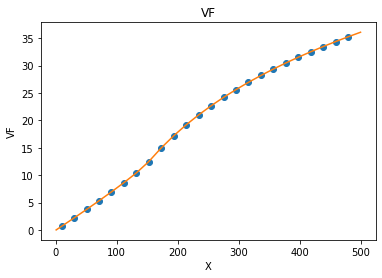

In [43]:
xmax = 100*N
xnew = np.linspace(1,xmax,100)
vf_new = soc_opt_sol.build_VF(xnew)

plt.plot(X[X < xmax], VF[X < xmax], 'o', xnew, vf_new)
plt.xlabel('X')
plt.ylabel('VF')
plt.title("VF")

Text(0.5, 1.0, 'XP')

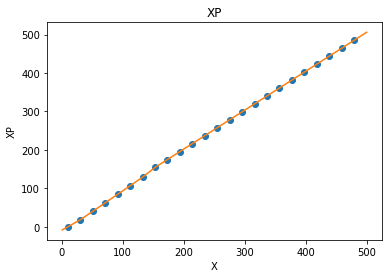

In [44]:
xp_new = soc_opt_sol.build_XP(xnew)

plt.plot(X[X < xmax], XP[X < xmax], 'o', xnew, xp_new)
plt.xlabel('X')
plt.ylabel('XP')
plt.title("XP")

<ipython-input-6-f5da8011af91>:8: RuntimeWarning: invalid value encountered in log
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-6-f5da8011af91>:8: RuntimeWarning: invalid value encountered in power
  return b0 + b1*np.log(x)/(b2 - (x**b3))


Text(0.5, 1.0, 'CP')

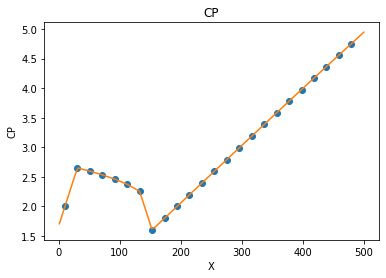

In [45]:
cp_new = soc_opt_sol.build_CP(X=xnew, XP=xp_new)

plt.plot(X[X < xmax], CP[X < xmax], 'o', xnew, cp_new)
plt.xlabel('X')
plt.ylabel('CP')
plt.title("CP")

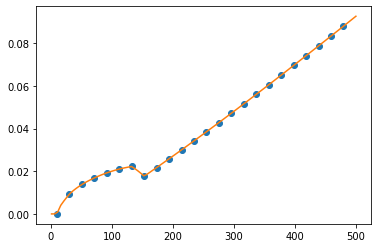

In [46]:
wp_new = soc_opt_sol.build_WP(X=xnew, XP=xp_new, CP=cp_new)

plt.plot(X[X < xmax], WP[X < xmax], 'o', xnew, wp_new)

Text(0.5, 1.0, 'VF')

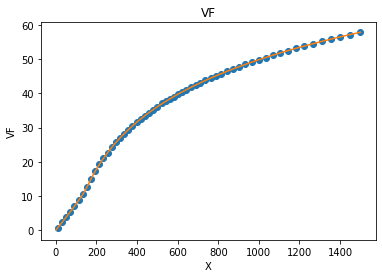

In [47]:
xmax = 300*N
xnew = np.linspace(1,xmax,100)
vf_new = soc_opt_sol.build_VF(xnew)

plt.plot(X[X < xmax], VF[X < xmax], 'o', xnew, vf_new)
plt.xlabel('X')
plt.ylabel('VF')
plt.title("VF")

Text(0.5, 1.0, 'XP')

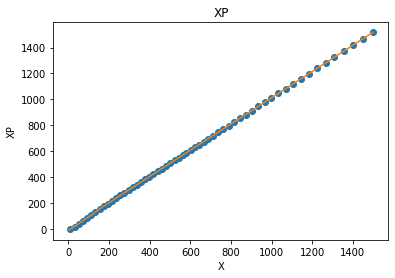

In [48]:
xp_new = soc_opt_sol.build_XP(xnew)

plt.plot(X[X < xmax], XP[X < xmax], 'o', xnew, xp_new)
plt.xlabel('X')
plt.ylabel('XP')
plt.title("XP")

<ipython-input-6-f5da8011af91>:8: RuntimeWarning: invalid value encountered in log
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-6-f5da8011af91>:8: RuntimeWarning: invalid value encountered in power
  return b0 + b1*np.log(x)/(b2 - (x**b3))


Text(0.5, 1.0, 'CP')

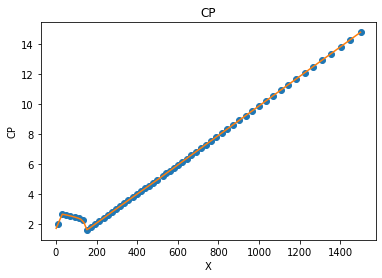

In [49]:
cp_new = soc_opt_sol.build_CP(X=xnew, XP=xp_new)

plt.plot(X[X < xmax], CP[X < xmax], 'o', xnew, cp_new)
plt.xlabel('X')
plt.ylabel('CP')
plt.title("CP")

Text(0.5, 1.0, 'WP')

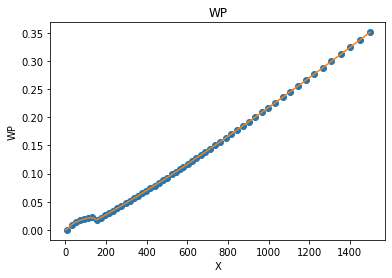

In [50]:
wp_new = soc_opt_sol.build_WP(X=xnew, XP=xp_new, CP=cp_new)

plt.plot(X[X < xmax], WP[X < xmax], 'o', xnew, wp_new)
plt.xlabel('X')
plt.ylabel('WP')
plt.title("WP")

Text(0.5, 1.0, 'VF')

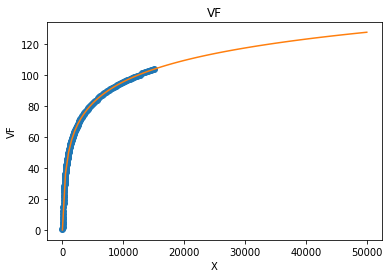

In [51]:
xmax = 1e4*N
xnew = np.linspace(1,xmax,100)
vf_new = soc_opt_sol.build_VF(xnew)

plt.plot(X[X < xmax], VF[X < xmax], 'o', xnew, vf_new)
plt.xlabel('X')
plt.ylabel('VF')
plt.title("VF")

Text(0.5, 1.0, 'XP')

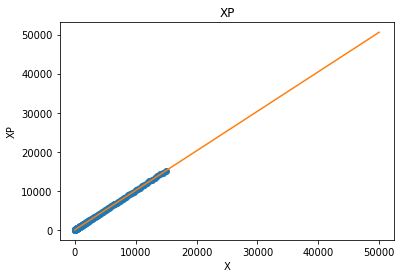

In [52]:
xp_new = soc_opt_sol.build_XP(xnew)

plt.plot(X[X < xmax], XP[X < xmax], 'o', xnew, xp_new)
plt.xlabel('X')
plt.ylabel('XP')
plt.title("XP")

<ipython-input-6-f5da8011af91>:8: RuntimeWarning: invalid value encountered in log
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-6-f5da8011af91>:8: RuntimeWarning: invalid value encountered in power
  return b0 + b1*np.log(x)/(b2 - (x**b3))


Text(0.5, 1.0, 'CP')

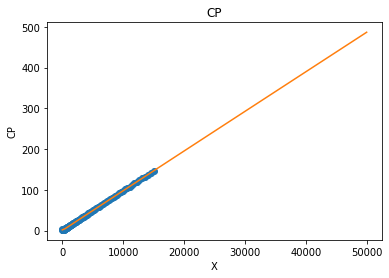

In [53]:
cp_new = soc_opt_sol.build_CP(X=xnew, XP=xp_new)

plt.plot(X[X < xmax], CP[X < xmax], 'o', xnew, cp_new)
plt.xlabel('X')
plt.ylabel('CP')
plt.title("CP")

Text(0.5, 1.0, 'WP')

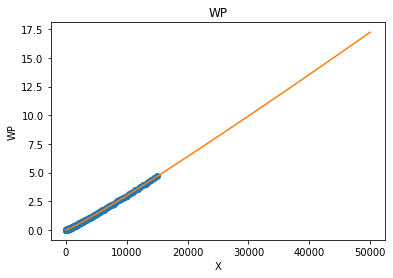

In [54]:
wp_new = soc_opt_sol.build_WP(X=xnew, XP=xp_new, CP=cp_new)

plt.plot(X[X < xmax], WP[X < xmax], 'o', xnew, wp_new)
plt.xlabel('X')
plt.ylabel('WP')
plt.title("WP")

Text(0.5, 1.0, 'XP')

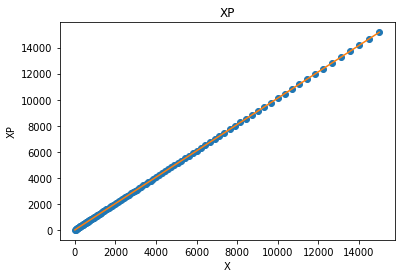

In [55]:
xmax = soc_opt_sol.erm.xgrid[-1] +1
xnew = np.linspace(1,xmax,100)
xp_new = soc_opt_sol.build_XP(xnew)

plt.plot(X[X < xmax], XP[X < xmax], 'o', xnew, xp_new)
plt.xlabel('X')
plt.ylabel('XP')
plt.title("XP")

### Visualizing the Optimal Consumption to Existential Risk Mitigation ratio as a function of available CPR (X) 

<ipython-input-6-f5da8011af91>:8: RuntimeWarning: invalid value encountered in log
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-6-f5da8011af91>:8: RuntimeWarning: invalid value encountered in power
  return b0 + b1*np.log(x)/(b2 - (x**b3))


Text(0.5, 1.0, 'CP/WP')

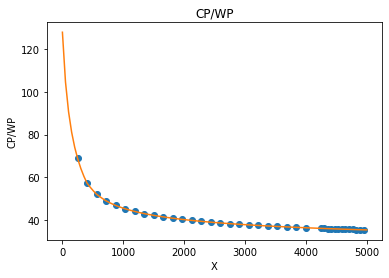

In [33]:
xmax = 1000*N
xnew = np.linspace(1,xmax,100)
xp_new = soc_opt_sol.build_XP(xnew)
cp_new = soc_opt_sol.build_CP(X=xnew, XP=xp_new)
wp_new = soc_opt_sol.build_WP(X=xnew, XP=xp_new, CP=cp_new)
cp_wp_ratio_new = cp_new/wp_new
CP_WP_ratio = CP/WP

plt.plot(X[(X < xmax)*(WP > 0)], 
         CP_WP_ratio[(X < xmax)*(WP > 0)], 'o', 
         xnew[wp_new > 0], 
         cp_wp_ratio_new[wp_new > 0])
plt.xlabel('X')
plt.ylabel('CP/WP')
plt.title("CP/WP")

In [34]:
xmax = 5e5
xnew = np.geomspace(1,xmax,20)
xp_new = soc_opt_sol.build_XP(xnew)
cp_new = soc_opt_sol.build_CP(X=xnew, XP=xp_new)
wp_new = soc_opt_sol.build_WP(X=xnew, XP=xp_new, CP=cp_new)
cp_wp_ratio_new = cp_new/wp_new

pd.DataFrame({
    'X': xnew,
    'CP/WP': cp_wp_ratio_new
}).style

<ipython-input-6-f5da8011af91>:8: RuntimeWarning: invalid value encountered in log
  return b0 + b1*np.log(x)/(b2 - (x**b3))
<ipython-input-6-f5da8011af91>:8: RuntimeWarning: invalid value encountered in power
  return b0 + b1*np.log(x)/(b2 - (x**b3))


,X,CP/WP
0,1.000000,127.869454
1,1.995013,127.251465
2,3.980078,126.044762
3,7.940308,123.736086
4,15.841021,119.484078
5,31.603046,112.160855
6,63.048497,100.831096
7,125.782589,85.723536
8,250.937934,68.742865
9,500.624509,53.889133
